<a href="https://colab.research.google.com/github/jiheddachraoui/AWR1642-cloud-point-reader/blob/main/yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4mygoxnf
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4mygoxnf
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=033af88963e18a4b1d2233d9ca88295d02e0dd81f0824a92d5c28a0d03d9151c
  Stored in directory: /tmp/pip-ephem-wheel-cache-jpg0p71o/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [44]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import requests
from io import BytesIO
import os.path as osp
import clip
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# 2. Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device, jit=False)

100%|███████████████████████████████████████| 244M/244M [00:05<00:00, 51.1MiB/s]


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f8313413130>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


In [7]:
umd_refs = np.load('/content/drive/MyDrive/refcocog/annotations/refs(umd).p', allow_pickle=True)

In [8]:
#add zero pad for images 

In [9]:
def zero_pad(x):
  width = 6
  padded_string = "%0*d" % (width, x)
  return padded_string

In [10]:
# getting all the sentences referiing an image:

def get_sents(x):
  sents = []
  for i in umd_refs:
    if i['image_id']==x:
      l = [ elt['sent'] for elt in i['sentences']] 
      sents.extend(l)
  return sents

In [11]:
# testing the function
get_sents(478885)

['a apple desktop computer',
 'the white imac computer that is also turned on',
 "a college student ' s pc keyboard",
 'a keyboard of the apple brand computer kept on a executive table',
 'the monitor in the middle of the other two']

In [12]:
d_train={}
d_test={}
d_val={}
IMAGE_DIR = "/content/drive/MyDrive/refcocog/images"
for e in umd_refs :
  if e['split'] == 'val' :
    d_val[osp.join(IMAGE_DIR,"COCO_train2014_000000"+zero_pad(e['image_id'])+".jpg")] = get_sents(e['image_id'])    
  elif e['split'] == 'train' :
    d_train[osp.join(IMAGE_DIR,"COCO_train2014_000000"+zero_pad(e['image_id'])+".jpg")] = get_sents(e['image_id'])
  else :
    d_test[osp.join(IMAGE_DIR,"COCO_train2014_000000"+zero_pad(e['image_id'])+".jpg")] = get_sents(e['image_id']) 

In [13]:
import re
import string

def text_cleaning (text):
  punctuation = ''.join([c for c in string.punctuation if c not in "','"])
  # Remove punctuation and convert to lowercase
  text = text.translate(str.maketrans('', '', punctuation)).lower()
  # Remove digits
  text = re.sub('\d', '', text)
  # Remove extra spaces
  text = re.sub('\s+', ' ', text).strip()
  return text

In [53]:
a='jaloul, y@a          ?         ghali!'
print(text_cleaning(a))

jaloul, ya ghali


In [14]:
def data_cleaning (d) :
  d_cleaned = {} 
  for image_path, descriptions in d.items():
    # Join all descriptions using a space character
    text = ','.join(descriptions)
    text = text_cleaning(text)
    d_cleaned[image_path] = text
  return d_cleaned

In [15]:
d_val_clean=data_cleaning (d_val)
d_train_clean=data_cleaning (d_train)
d_test_clean=data_cleaning (d_test)

In [58]:
l_descrip_val = []
l_img_val= []
for image_path, dec in d_val_clean.items():
  if os.path.isfile(image_path) :
    l_descrip_val.append(dec)
    l_img_val.append(image_path)

print(len(l_img_val),len(l_descrip_val))

1299 1299


In [56]:
l_descrip_train = []
l_img_train= []
for image_path, dec in d_train_clean.items():
  if os.path.isfile(image_path) :
    l_descrip_train.append(dec)
    l_img_train.append(image_path)

print(len(l_img_train),len(l_descrip_train))

21877 21877


In [57]:
l_descrip_test = []
l_img_test= []
for image_path, dec in d_test_clean.items():
  if os.path.isfile(image_path) :
    l_descrip_test.append(dec)
    l_img_test.append(image_path)

print(len(l_img_test),len(l_descrip_test))

2599 2599


In [87]:
print(len(l_descrip_val[2]))

1299


In [95]:
print(l_descrip_val[1:3])

['black and white dog with pointy ears,the black and white dog nearest the wall,black dog,a solid black dog,a black and white dog lying beside a black dog,a black and white dog lying on a bed with two other dogs,tan and white dog on the edge of a bed,a tan dog', 'small cow laying down,the front most cow to the right of other cows,cow with bell around its neck looking to the left,the cow sitting by itself,a cow that is resting seperately']


In [96]:
print(clip.tokenize(l_descrip_val[1:3]))

tensor([[49406,  1449,   537,  1579,  1929,   593,  9074,   744,  9861,   267,
           518,  1449,   537,  1579,  1929, 18985,   518,  2569,   267,  1449,
          1929,   267,   320,  6148,  1449,  1929,   267,   320,  1449,   537,
          1579,  1929,  7175, 13519,   320,  1449,  1929,   267,   320,  1449,
           537,  1579,  1929,  7175,   525,   320,  2722,   593,  1237,  1010,
          3255,   267,  5039,   537,  1579,  1929,   525,   518,  5461,   539,
           320,  2722,   267,   320,  5039,  1929, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,  2442,  9706, 12333,  1136,   267,   518,  2184,  1096,  9706,
           531,   518,  1155,   539,  1010, 15204,   267,  9706,   593,  3718,
          1630,   902,  6906,  1312,   531,   518,  1823,   267,   518,  9706,
          4919,   638,  7290,   267,   320,  9706,   682,   533, 18044,   567,
           703,  3862, 49407,     0,     0,     0,     0,     0,     0, 

In [107]:
class image_title_dataset(Dataset):
  def __init__(self, list_image_path,list_txt):
    self.image_path = list_image_path
    self.title  = clip.tokenize(list_txt) #you can tokenize everything at once in here(slow at the beginning), or tokenize it in the training loop.

  def __len__(self):
    return len(self.title)
    
  def __getitem__(self, idx):
    image = preprocess(Image.open(self.image_path[idx])) # Image from PIL module
    title = self.title[idx]
    return image,title

In [108]:
dataset = image_title_dataset(l_img_val,l_descrip_val)
train_dataloader = DataLoader(dataset,batch_size = 32) #Define your own dataloader

RuntimeError: ignored

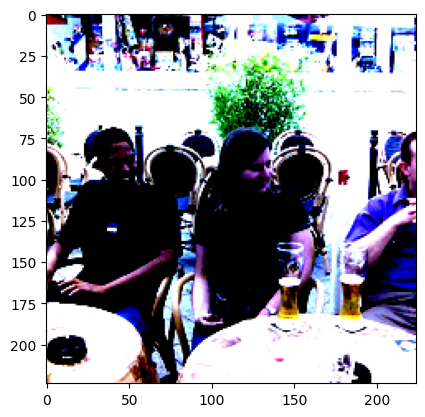

In [97]:
image, title = dataset[0]
#print(title)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()

In [98]:
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

In [104]:
if device == "cpu":
  model.float()
else :
  clip.model.convert_weights(model)

AttributeError: ignored

In [105]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset

In [106]:
EPOCH=2
metrics = {'train_loss': [], 'val_loss': []}
for epoch in range(EPOCH):

  train_losses = []
  model.train()  # set the model to training mode

  for batch in train_dataloader :
    optimizer.zero_grad()
    
    images,texts = batch 
    
    images= images.to(device)
    texts = texts.to(device)
    
    logits_per_image, logits_per_text = model(images, texts)
    
    ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
    
    total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
    total_loss.backward()
    
    if device == "cpu":
      optimizer.step()
    else : 
      convert_models_to_fp32(model)
      optimizer.step()
      clip.model.convert_weights(model)

    train_losses.append(total_loss.item())  
  train_loss = sum(train_losses) / len(train_losses)    
  # Print progress
  print(f'Epoch {epoch + 1}/{EPOCH}, Train Loss: {train_loss:.4f}') 

RuntimeError: ignored

In [ ]:
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"/content/drive/MyDrive/model_10.pt")